# Milestone 2

In [1]:
%cd ..
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts_m2 import *


c:\Users\001\OneDrive\Desktop\GUC\semester 10\nlp\NLP_PROJECT_111\QA Task milestone


### 1. Exploring the Dataset

In [2]:
# Loading the training data
import json 

with open('data/m2_train.json', 'r') as f:
    squad_data = json.load(f)

print(squad_data['data'][0]['paragraphs'][0].keys())

print(json.dumps(squad_data['data'][0], indent=2))

dict_keys(['qas', 'context'])
{
  "title": "Beyonc\u00e9",
  "paragraphs": [
    {
      "qas": [
        {
          "question": "When did Beyonce start becoming popular?",
          "id": "56be85543aeaaa14008c9063",
          "answers": [
            {
              "text": "in the late 1990s",
              "answer_start": 269
            }
          ],
          "is_impossible": false
        },
        {
          "question": "What areas did Beyonce compete in when she was growing up?",
          "id": "56be85543aeaaa14008c9065",
          "answers": [
            {
              "text": "singing and dancing",
              "answer_start": 207
            }
          ],
          "is_impossible": false
        },
        {
          "question": "When did Beyonce leave Destiny's Child and become a solo singer?",
          "id": "56be85543aeaaa14008c9066",
          "answers": [
            {
              "text": "2003",
              "answer_start": 526
            }
          ],


In [3]:
# Counting the number of answerable and unanswerable questions
num_answerable = 0
num_unanswerable = 0

for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                num_unanswerable += 1
            else:
                num_answerable += 1

print("Number of answerable questions: ", num_answerable)
print("Number of unanswerable questions: ", num_unanswerable)
print("Number of QA pairs: ", num_answerable + num_unanswerable)

Number of answerable questions:  86821
Number of unanswerable questions:  43498
Number of QA pairs:  130319


Answerable vs. Unanswerable Questions in SQuAD 2.0

- **Answerable Questions:** The correct answer exists within the given passage, and the model must extract the exact span.
- **Unanswerable Questions:** The passage does not contain the answer, and the model should predict "No Answer."

SQuAD 2.0 introduces unanswerable questions to make the task more challenging, requiring models to distinguish between when an answer is present and when it is not.

In this notebook, we will use answerable questions only in the subset we will be training our neural networks on

### 2. Preprocessing the dataset

In [4]:
# Clean text function
import re

def clean_text(text: str, is_question: bool=False):
    """
    Cleans text by removing extra spaces, newline characters, and special symbols.
    """
    if is_question:
        text = text.replace("\n", " ").replace("\t", " ")  # Remove newlines & tabs
        text = re.sub(r"\s+", " ", text)  # Remove extra spaces
        text = text.strip()  # Trim leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Testing the clean_text function on a sample text
sample_text = "   This is a \n\n\t sample    text.    "
print("Original text:", sample_text)
print("Cleaned text:", clean_text(sample_text))

Original text:    This is a 

	 sample    text.    
Cleaned text:    this is a 

	 sample    text.    


In [5]:
# Load and process the SQuAD dataset using the clean_text function
import json

def load_and_process_squad(filepath, max_samples=20000):
    """
    Loads, cleans, and extracts answerable questions from the SQuAD dataset.

    Args:
        filepath (str): Path to the SQuAD JSON file.
        max_samples (int): Maximum number of answerable questions to load.

    Returns:
        List[dict]: A list of cleaned question-answer pairs.
    """
    with open(filepath, "r") as f:
        squad_data = json.load(f)

    data = []
    for article in squad_data["data"]:
        for paragraph in article["paragraphs"]:
            context = clean_text(paragraph["context"]) 
            for qa in paragraph["qas"]:
                if qa["is_impossible"]:  
                    continue
                
                question = clean_text(qa["question"], is_question=True) 
                answer_text = clean_text(qa["answers"][0]["text"])  
                answer_start = qa["answers"][0]["answer_start"]
                
                data.append({
                    "context": context, 
                    "question": question, 
                    "answer": answer_text, 
                    "answer_start": answer_start, 
                    "answer_end": answer_start + len(answer_text)})


    data.sort(key=lambda x: (len(x["context"]), len(x["question"])))
    # Limit the number of samples if specified
    if max_samples > 0:
        data = data[:max_samples]
    return data

# Load and process the SQuAD dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=-1)
dev_samples = load_and_process_squad("data/m2_dev.json", max_samples=2000)

print("Number of QA pairs in train data:", len(train_dataset))
print("Training sample:", train_dataset[0].keys())
print("\n")
print("Number of QA pairs in test data:", len(dev_samples))
print("Dev sample:", dev_samples[0].keys())


Number of QA pairs in train data: 86821
Training sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


Number of QA pairs in test data: 2000
Dev sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


### 3. Tokenization

In [6]:
unique_words = set()

for sample in train_dataset:
    context = sample["context"]
    question = sample["question"]
    answer = sample["answer"]

    unique_words.update(set(re.findall(r"\w+", context)))
    unique_words.update(set(re.findall(r"\w+", question)))
    unique_words.update(set(re.findall(r"\w+", answer)))

                
# Print the number of unique words
print("Number of unique words in the training set:", len(unique_words))

Number of unique words in the training set: 82597


In [7]:
combined_text = []
for sample in train_dataset:
    combined_text.append(sample["context"])
    combined_text.append(sample["question"])
    combined_text.append(sample["answer"])

# Join all text samples into one corpus (you can also use '\n'.join for a more distinct separation)
combined_text = "\n".join(combined_text)


In [8]:
# Training the tokenizer
from scripts_m2 import *

# Creating / Loading the tokenizer
tokenizer = BPETokenizer()

# Training the tokenizer if not already trained
tokenizer.train(combined_text=combined_text.split("/n"), vocab_size=10000)


Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [9]:
# Encoding a Question
example_question = train_dataset[4]["question"]
tokenized_output, attention_mask = tokenizer.encode(example_question)
print("Tokenized Question:", tokenized_output)
print("Length of Tokenized Question:", len(tokenized_output))
print("Attention Mask:", attention_mask)

# Decoding the tokenized output
decoded_output = tokenizer.decode(tokenized_output)
print("Decoded Question:", decoded_output)

Tokenized Question: [3, 2441, 1997, 1966, 4721, 2776, 1974, 3539, 1978, 7873, 3120, 1390, 4]
Length of Tokenized Question: 13
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Question: where is the oklahoma school of science and mathematics located ?


In [10]:
# Changing the max tokenizer length
tokenizer.set_max_length(25)

In [11]:
# Encoding an answer
example_answer = train_dataset[4]["answer"]
tokenized_answer, attention_mask = tokenizer.encode(example_answer)
print("Tokenized Answer:", tokenized_answer)
print("Length of Tokenized Answer:", len(tokenized_answer))
print("Attention Mask:", attention_mask)

# Decoding the tokenized answer
decoded_answer = tokenizer.decode(tokenized_answer)
print("Decoded Answer:", decoded_answer)

Tokenized Answer: [3, 4721, 2251, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of Tokenized Answer: 25
Attention Mask: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Answer: oklahoma city


### 4. Dataset & Data Loaders

In [12]:
# Getting the dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_dataset = load_and_process_squad("data/m2_dev.json", max_samples=2000)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

Number of training samples: 20000
Number of dev samples: 2000


In [13]:
# Create the tokenizer
tokenizer = BPETokenizer()
# Train the tokenizer
tokenizer.train(combined_text=combined_text.split("\n"), vocab_size=10000)

Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [14]:
# View the training data
random_idx = np.random.randint(0, len(train_dataset))

# Print the random sample
print(train_dataset[random_idx].keys())
print("Training data sample:")
print(train_dataset[random_idx]["context"])
print(train_dataset[random_idx]["question"])
print(train_dataset[random_idx]["answer"])
print("Answer start:", train_dataset[random_idx]["answer_start"])
print("Answer end:", train_dataset[random_idx]["answer_end"])
print("Length of the training examples:", len(train_dataset))

dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])
Training data sample:
dst clock shifts sometimes complicate timekeeping and can disrupt travel, billing, record keeping, medical devices, heavy equipment, and sleep patterns. computer software can often adjust clocks automatically, but policy changes by various jurisdictions of the dates and timings of dst may be confusing.
when the clock on your laptop adjusts to dst without you resetting the clock, what is controlling the change?
computer software
Answer start: 153
Answer end: 170
Length of the training examples: 20000


In [15]:
q = tokenizer.encode(train_dataset[4]["question"])[0]
tokenizer.decode(q)

'where is the oklahoma school of science and mathematics located ?'

In [16]:
# Viewing the length of the longest question, context, and answer
max_context_length = max(len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset)
max_question_length = max(len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset)
max_answer_length = max(len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset)

print("Max context length:", max_context_length)
print("Max question length:", max_question_length)
print("Max answer length:", max_answer_length)

Max context length: 205
Max question length: 64
Max answer length: 75


Summary Statistics for Context Lengths:
Number of questions: 20000
Number of outliers: 18
Minimum: 29
Q1 (25%): 83.0
Median: 110.0
Q3 (75%): 124.0
Maximum: 205
Interquartile Range (IQR): 41.0
95th Percentile: 143.0
97th Percentile: 149.0
99th Percentile: 160.0


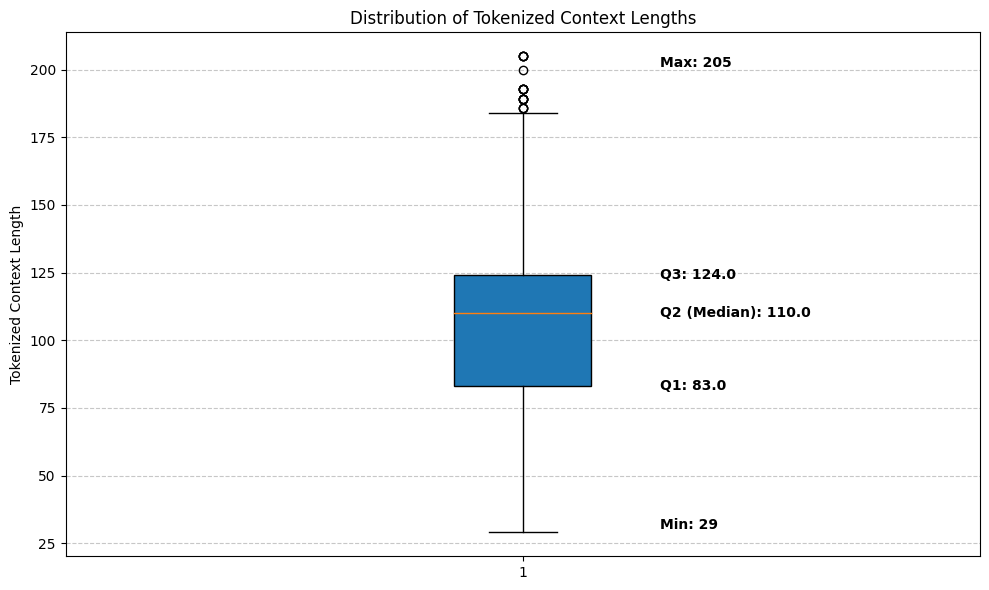

In [17]:
# Visualizing the distribution of tokenized question lengths
context_lengths = [len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context Lengths")
plt.ylabel("Tokenized Context Length")

# Calculate and display quartiles
quartiles = np.percentile(context_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_lengths)
max_val = np.max(context_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Context Lengths:")
print("Number of questions:", len(context_lengths))
print("Number of outliers:", len([x for x in context_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Question Lengths:
Number of questions: 20000
Number of outliers: 407
Minimum: 6
Q1 (25%): 12.0
Median: 15.0
Q3 (75%): 18.0
Maximum: 64
Interquartile Range (IQR): 6.0
95th Percentile: 24.0
97th Percentile: 26.0
99th Percentile: 30.0


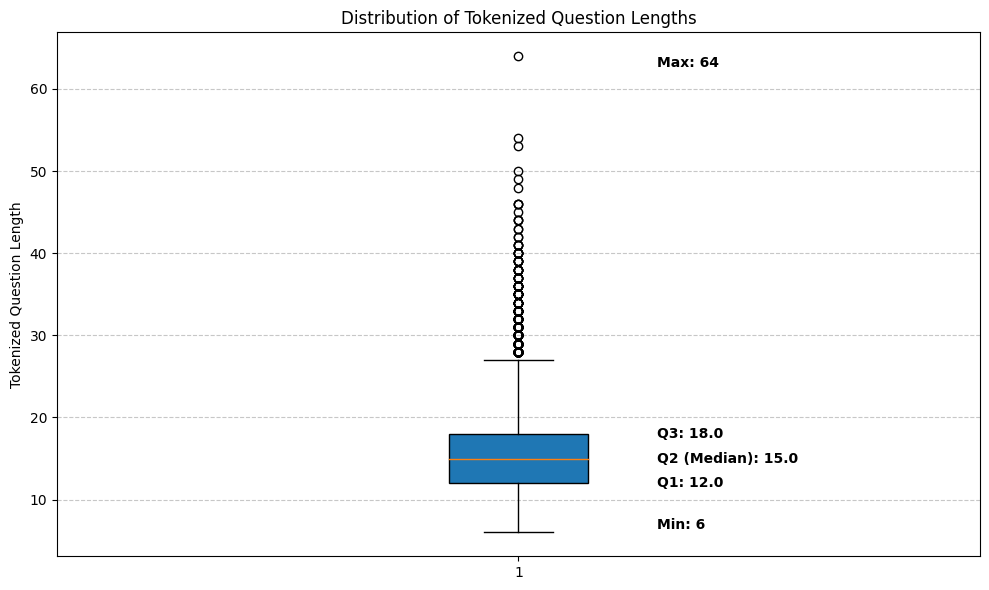

In [18]:
# Visualizing the distribution of tokenized question lengths
question_lengths = [len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Question Lengths")
plt.ylabel("Tokenized Question Length")

# Calculate and display quartiles
quartiles = np.percentile(question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(question_lengths)
max_val = np.max(question_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Question Lengths:")
print("Number of questions:", len(question_lengths))
print("Number of outliers:", len([x for x in question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Answer Lengths:
Number of answers:  20000
Number of outliers:  1705
Minimum: 3
Q1 (25%): 4.0
Median: 5.0
Q3 (75%): 7.0
Maximum: 75
Interquartile Range (IQR): 3.0
95th Percentile: 14.0
97th Percentile: 18.0
99th Percentile: 25.0


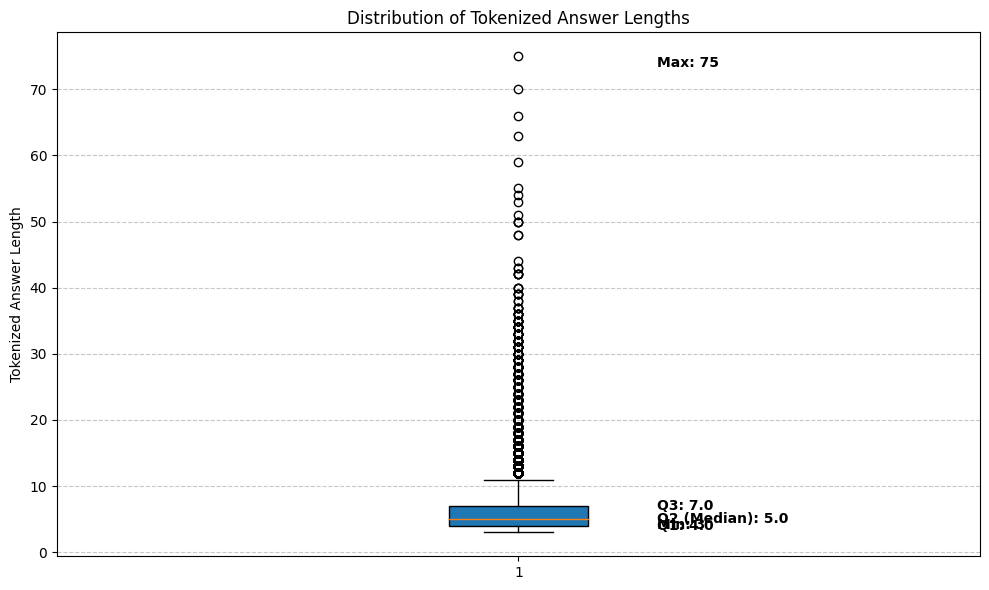

In [19]:
# Visualizing the distribution of tokenized answer lengths
answer_lengths = [len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(answer_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Answer Lengths")
plt.ylabel("Tokenized Answer Length")
# Calculate and display quartiles
quartiles = np.percentile(answer_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(answer_lengths)
max_val = np.max(answer_lengths)

print(f"Summary Statistics for Answer Lengths:")
print("Number of answers: ", len(answer_lengths))
print("Number of outliers: ", len([x for x in answer_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in answer_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary Statistics for context + question Lengths:
Number of context + question:  20000
Number of outliers:  10
Minimum: 39
Q1 (25%): 97.0
Median: 124.0
Q3 (75%): 139.0
Maximum: 224
Interquartile Range (IQR): 42.0
95th Percentile: 159.0
97th Percentile: 164.0
99th Percentile: 175.0


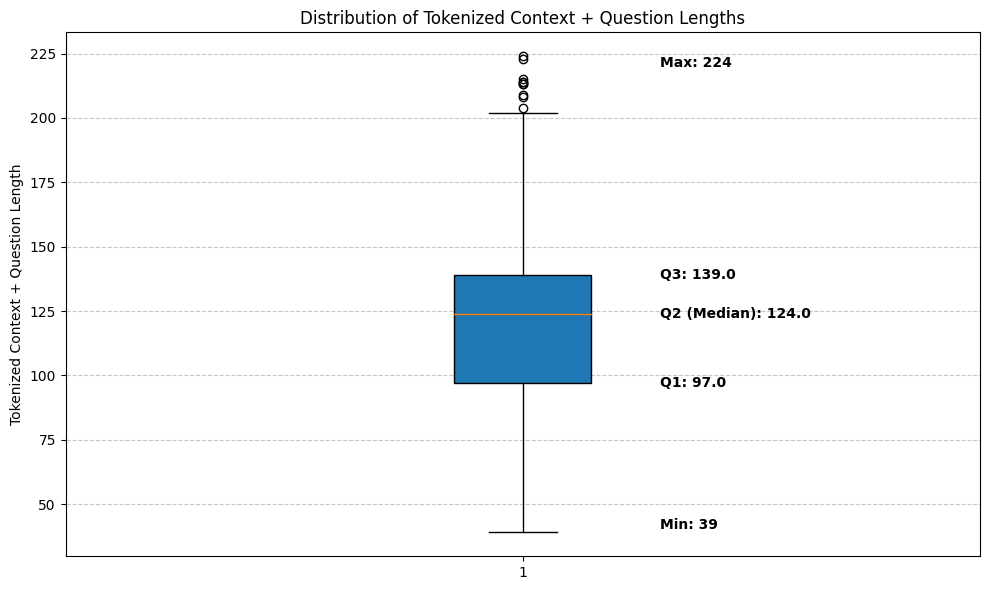

In [20]:
# Visualizing the distribution of tokenized answer lengths
context_question_lengths = [len(tokenizer.encode_two_texts(sample["context"], sample["question"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context + Question Lengths")
plt.ylabel("Tokenized Context + Question Length")
# Calculate and display quartiles
quartiles = np.percentile(context_question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_question_lengths)
max_val = np.max(context_question_lengths)

print(f"Summary Statistics for context + question Lengths:")
print("Number of context + question: ", len(context_question_lengths))
print("Number of outliers: ", len([x for x in context_question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So for the transformer based models we can use the max length of the question and answer as follows:
1. `Answers Max Length`: 25 tokens
2. `Question Max Length`: 30 tokens
3. `Context Max Length`: 160 tokens
4. `Context + Question Length`: 160+30+1 (+1 for [SEP]) We could have used 175 as it is the 99th percentile but we will use 191 instead


This would give us a good tradeoff between the length of the sequence without using a lot of padding.

In [21]:
# Creating dataset
tokenizer = BPETokenizer()
train_data = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_data = load_and_process_squad("data/m2_dev.json", max_samples=2000)

context_max_length = 160
question_max_length = 30
answer_max_length = 25
train_dataset = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
dev_dataset = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset))
print("Sample from the dataset:")
print("Question encoded:", train_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset[random_idx]["context"].tolist()))
print("\n\n")

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset[random_idx]["answer_start"])
print("Answer End:", dev_dataset[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset[random_idx]["context"][dev_dataset[random_idx]["answer_start"]:dev_dataset[random_idx]["answer_end"]+1].tolist()))


Loading tokenizer from ./tokenizers/tokenizer.json...
Filtered dataset size: 19993 out of original 20000
Filtered dataset size: 1996 out of original 2000
Number of training samples: 19993
Number of dev samples: 1996
Sample from the dataset:
Question encoded: tensor([   3, 2087, 5343, 2170, 3123, 4466, 2038, 5918, 2910, 6784, 2743, 1390,
           4,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Question decoded:  what location has become famous for bird overshooters ?
Answer encoded: tensor([   3, 3362, 6842, 6293, 2379, 3538,    4,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  point pelee national park
Context encoded: tensor([   3, 3242, 2470, 4272, 2361, 9414, 2178, 2602, 1978, 5530, 4114, 2178,
        7076, 8085, 1321, 2156, 2361, 2114, 2979, 1989, 8412, 4670, 2178, 3504,
        5439, 1990, 1979, 1966, 1314, 5347, 2910, 

In [22]:
# Creating Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

for batch in train_dataloader:
    print(batch.keys())
    print(batch['context_question'].shape)
    print(batch['question'].shape)
    print(batch['answer'].shape)
    print(batch['attention_mask_question'].shape)
    print(batch['attention_mask_answer'].shape)
    print(batch['attention_mask_context_question'].shape)
    print(batch['answer_start'], batch['answer_end'])
    print(batch['context_question_type_mask'].shape)
    print("-" * 50)
    input_ids = batch['context_question']
    attention_mask = batch['attention_mask_context_question']
    token_type_ids = batch['context_question_type_mask']
    break

dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end', 'context_question_type_mask'])
torch.Size([32, 191])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 191])
tensor([84, 25,  3,  9, 58, 91, 51,  0, 57, 69, 36,  5, 15, 46, 30, 30, 23,  7,
        47, 25,  9, 21, 15, 50,  2, 56,  2, 89, 96, 60,  0, 49]) tensor([ 86,  25,   6,  12,  58,  93,  51,   2,  75,  71,  38,   7,  29,  51,
         30,  32,  26,   9,  47,  27,  14,  24,  18,  54,   2,  57,   3,  89,
        101,  64,   3,  49])
torch.Size([32, 191])
--------------------------------------------------


In [23]:
context_max_length + question_max_length

190

### 5. Phase 1: Model Training

#### Context [SEP] Question

In [29]:
def train_qa_context_bidaf_model(model: nn.Module,
                           train_dataloader: DataLoader,
                           criterion: nn.Module,
                           optimizer: optim.Optimizer,
                           device: torch.device,
                           num_epochs: int,
                           val_dataloader: DataLoader=None,
                           evaluate_val_dataset: bool=False) -> None:
    """
    Train and evaluate the QA context model.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to train on (CPU or GPU).
        num_epochs (int): Number of epochs to train for.
        val_dataloader (DataLoader, optional): DataLoader for validation data.
        evaluate_val_dataset (bool): Whether to evaluate on the validation dataset after each epoch.

    """
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            context = batch['context'].to(device)
            question = batch['question'].to(device)
            answer_start = batch['answer_start'].contiguous().view(-1).to(device)
            answer_end = batch['answer_end'].contiguous().view(-1).to(device)
            optimizer.zero_grad()

            # Forward pass
            start_logits, end_logits = model(context, question)

            start_logits = start_logits.contiguous().view(-1, start_logits.size(-1))
            end_logits = end_logits.contiguous().view(-1, end_logits.size(-1))

            loss_start = criterion(start_logits, answer_start)
            loss_end = criterion(end_logits, answer_end)
            loss = loss_start + loss_end

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_dataloader):.4f}")
        
        train_metrics = evaluate_qa_context_bidaf_model(model, train_dataloader, criterion, device, prefix_str="Training")
        if evaluate_val_dataset and val_dataloader is not None:
            val_metrics = evaluate_qa_context_bidaf_model(model, val_dataloader, criterion, device) 
        print('-'*50)

def evaluate_qa_context_bidaf_model(model: nn.Module, 
                              dataloader: DataLoader,
                              criterion: nn.Module,
                              device: torch.device,
                              prefix_str: str="Validation") -> Tuple[float, Dict[str, float]]:
    """
    Evaluate the QA context model.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to evaluate on (CPU or GPU).
        prefix_str (str): Prefix string for logging.

    Returns:
        Tuple[float, Dict[str, float]]: Validation loss and evaluation metrics.
    """
    model.eval()
    total_loss = 0
    y_true_start = []
    y_true_end = []
    y_pred_start = []
    y_pred_end = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            context = batch['context'].to(device)
            question = batch['question'].to(device)
            answer_start = batch['answer_start'].contiguous().view(-1).to(device)
            answer_end = batch['answer_end'].contiguous().view(-1).to(device)

            start_logits, end_logits = model(context, question)

            start_logits = start_logits.contiguous().view(-1, start_logits.size(-1))
            end_logits = end_logits.contiguous().view(-1, end_logits.size(-1))
            
            loss_start = criterion(start_logits, answer_start)
            loss_end = criterion(end_logits, answer_end)
            loss = loss_start + loss_end

            total_loss += loss.item()

            # Collect predictions and true values
            y_true_start.extend(answer_start.cpu().numpy())
            y_true_end.extend(answer_end.cpu().numpy())
            y_pred_start.extend(start_logits.argmax(dim=-1).cpu().numpy())
            y_pred_end.extend(end_logits.argmax(dim=-1).cpu().numpy())

    total_loss /= len(dataloader)
    print(f"{prefix_str} Loss: {total_loss:.4f}")
    
    metrics = evaluate_qa_predictions(pred_start=np.array(y_pred_start),
                                      pred_end=np.array(y_pred_end),
                                      gt_start=np.array(y_true_start),
                                      gt_end=np.array(y_true_end))
    print(f"{prefix_str} Metrics: {metrics}")
    
    return total_loss, metrics

# =======================
# Main Routine Example
# =======================
# Hyperparameters (adjust as needed)
vocab_size = 50000         # Size of the vocabulary
embed_dim = 300            # Dimensionality of the embeddings
hidden_size = 100          # Base hidden size; BiLSTM outputs will be 2*hidden_size
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the BiDAF model
model = BiDAF(vocab_size, embed_dim, hidden_size, dropout=dropout)
model = model.to(device)

# Setup an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Example training loop
train_qa_context_bidaf_model(model=model,
                            train_dataloader=train_dataloader,
                            criterion=nn.CrossEntropyLoss(ignore_index=1),
                            optimizer=optimizer,
                            device=device,
                            num_epochs=20,
                            val_dataloader=dev_dataloader,
                            evaluate_val_dataset=True)


Epoch 1/20: 100%|██████████| 625/625 [00:22<00:00, 27.83it/s, loss=6.06]


Epoch 1 Loss: 7.4089


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.66it/s]


Training Loss: 5.1510
Training Metrics: {'start_accuracy': 0.3208122842995048, 'start_precision': 0.32278575000406806, 'start_recall': 0.3208122842995048, 'start_f1_score': 0.319468427825241, 'end_accuracy': 0.3421697594157955, 'end_precision': 0.3470841229070526, 'end_recall': 0.3421697594157955, 'end_f1_score': 0.34073742645569216, 'joint_exact_match': 0.2015205321862652, 'span_overlap_f1': 0.31331246204144664}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.76it/s]


Validation Loss: 5.9687
Validation Metrics: {'start_accuracy': 0.25701402805611223, 'start_precision': 0.26903887801215487, 'start_recall': 0.25701402805611223, 'start_f1_score': 0.2544832497325025, 'end_accuracy': 0.2605210420841683, 'end_precision': 0.27901480864781725, 'end_recall': 0.2605210420841683, 'end_f1_score': 0.25762490386528936, 'joint_exact_match': 0.15030060120240482, 'span_overlap_f1': 0.2572985093385385}
--------------------------------------------------


Epoch 2/20: 100%|██████████| 625/625 [00:22<00:00, 27.64it/s, loss=3.97]


Epoch 2 Loss: 4.7040


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 49.66it/s]


Training Loss: 3.2532
Training Metrics: {'start_accuracy': 0.5396888911118891, 'start_precision': 0.5441950776575333, 'start_recall': 0.5396888911118891, 'start_f1_score': 0.5392180098533274, 'end_accuracy': 0.5667983794328015, 'end_precision': 0.5684173423929665, 'end_recall': 0.5667983794328015, 'end_f1_score': 0.5656994710978404, 'joint_exact_match': 0.4194468063822338, 'span_overlap_f1': 0.5815945369199745}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.24it/s]


Validation Loss: 4.6460
Validation Metrics: {'start_accuracy': 0.40781563126252507, 'start_precision': 0.41932425108418353, 'start_recall': 0.40781563126252507, 'start_f1_score': 0.40336382884231065, 'end_accuracy': 0.41583166332665333, 'end_precision': 0.42864189093864646, 'end_recall': 0.41583166332665333, 'end_f1_score': 0.41287419195199854, 'joint_exact_match': 0.28256513026052105, 'span_overlap_f1': 0.44028136548123886}
--------------------------------------------------


Epoch 3/20: 100%|██████████| 625/625 [00:22<00:00, 28.37it/s, loss=4.08]


Epoch 3 Loss: 3.6026


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.84it/s]


Training Loss: 2.5492
Training Metrics: {'start_accuracy': 0.6354223978392437, 'start_precision': 0.6380253791943994, 'start_recall': 0.6354223978392437, 'start_f1_score': 0.6353414833438015, 'end_accuracy': 0.6458260391136897, 'end_precision': 0.6474571812572513, 'end_recall': 0.6458260391136897, 'end_f1_score': 0.6452224612707422, 'joint_exact_match': 0.5115290351623069, 'span_overlap_f1': 0.670870164546603}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 46.94it/s]


Validation Loss: 4.5272
Validation Metrics: {'start_accuracy': 0.4253507014028056, 'start_precision': 0.4420450378265917, 'start_recall': 0.4253507014028056, 'start_f1_score': 0.4238321865612305, 'end_accuracy': 0.4278557114228457, 'end_precision': 0.44446608924145004, 'end_recall': 0.4278557114228457, 'end_f1_score': 0.4268007431968627, 'joint_exact_match': 0.2995991983967936, 'span_overlap_f1': 0.4627321726361957}
--------------------------------------------------


Epoch 4/20: 100%|██████████| 625/625 [00:22<00:00, 28.22it/s, loss=2.71]


Epoch 4 Loss: 2.9775


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.16it/s]


Training Loss: 1.9195
Training Metrics: {'start_accuracy': 0.7134497073975892, 'start_precision': 0.715189863530756, 'start_recall': 0.7134497073975892, 'start_f1_score': 0.713510293987229, 'end_accuracy': 0.7469114189966488, 'end_precision': 0.7491630260733342, 'end_recall': 0.7469114189966488, 'end_f1_score': 0.7468394693704714, 'joint_exact_match': 0.6083629270244586, 'span_overlap_f1': 0.7660048268375692}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.40it/s]


Validation Loss: 4.4925
Validation Metrics: {'start_accuracy': 0.4258517034068136, 'start_precision': 0.44060930874485416, 'start_recall': 0.4258517034068136, 'start_f1_score': 0.4222335202477603, 'end_accuracy': 0.43837675350701405, 'end_precision': 0.4550030653257967, 'end_recall': 0.43837675350701405, 'end_f1_score': 0.43795997554625743, 'joint_exact_match': 0.3106212424849699, 'span_overlap_f1': 0.4769828411979448}
--------------------------------------------------


Epoch 5/20: 100%|██████████| 625/625 [00:22<00:00, 28.39it/s, loss=3.27]


Epoch 5 Loss: 2.5011


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.20it/s]


Training Loss: 1.5356
Training Metrics: {'start_accuracy': 0.760816285699995, 'start_precision': 0.7635392517402378, 'start_recall': 0.760816285699995, 'start_f1_score': 0.7608288937076702, 'end_accuracy': 0.7909768418946631, 'end_precision': 0.7919108048256385, 'end_recall': 0.7909768418946631, 'end_f1_score': 0.7902609407887629, 'joint_exact_match': 0.6610313609763417, 'span_overlap_f1': 0.8083926786035768}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.45it/s]


Validation Loss: 4.7411
Validation Metrics: {'start_accuracy': 0.4218436873747495, 'start_precision': 0.440995173714841, 'start_recall': 0.4218436873747495, 'start_f1_score': 0.4197927742577451, 'end_accuracy': 0.42635270541082165, 'end_precision': 0.44707044706360427, 'end_recall': 0.42635270541082165, 'end_f1_score': 0.42555695042665936, 'joint_exact_match': 0.29609218436873747, 'span_overlap_f1': 0.4583855331444967}
--------------------------------------------------


Epoch 6/20: 100%|██████████| 625/625 [00:21<00:00, 28.43it/s, loss=2.64] 


Epoch 6 Loss: 2.1524


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.93it/s]


Training Loss: 1.1710
Training Metrics: {'start_accuracy': 0.8112339318761567, 'start_precision': 0.8125107313415177, 'start_recall': 0.8112339318761567, 'start_f1_score': 0.8112048761871046, 'end_accuracy': 0.8474466063122092, 'end_precision': 0.8485168501141391, 'end_recall': 0.8474466063122092, 'end_f1_score': 0.8471328316811612, 'joint_exact_match': 0.7274045916070625, 'span_overlap_f1': 0.8637741264241806}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.40it/s]


Validation Loss: 4.9858
Validation Metrics: {'start_accuracy': 0.41783567134268534, 'start_precision': 0.4343003513781215, 'start_recall': 0.41783567134268534, 'start_f1_score': 0.41540944906878274, 'end_accuracy': 0.4273547094188377, 'end_precision': 0.4441964448776171, 'end_recall': 0.4273547094188377, 'end_f1_score': 0.4268625893909387, 'joint_exact_match': 0.2905811623246493, 'span_overlap_f1': 0.47274902932502527}
--------------------------------------------------


Epoch 7/20: 100%|██████████| 625/625 [00:21<00:00, 28.48it/s, loss=1.69] 


Epoch 7 Loss: 1.8431


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.77it/s]


Training Loss: 0.9948
Training Metrics: {'start_accuracy': 0.835592457360076, 'start_precision': 0.8365201147848075, 'start_recall': 0.835592457360076, 'start_f1_score': 0.8354534884943493, 'end_accuracy': 0.8659530835792527, 'end_precision': 0.8668883744796128, 'end_recall': 0.8659530835792527, 'end_f1_score': 0.865642863337542, 'joint_exact_match': 0.7573650777772221, 'span_overlap_f1': 0.883187866354291}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.70it/s]


Validation Loss: 5.1830
Validation Metrics: {'start_accuracy': 0.4308617234468938, 'start_precision': 0.44513089755801827, 'start_recall': 0.4308617234468938, 'start_f1_score': 0.42879542041400703, 'end_accuracy': 0.44438877755511025, 'end_precision': 0.46536472950412566, 'end_recall': 0.44438877755511025, 'end_f1_score': 0.44379248375258473, 'joint_exact_match': 0.3151302605210421, 'span_overlap_f1': 0.47710772202393076}
--------------------------------------------------


Epoch 8/20: 100%|██████████| 625/625 [00:22<00:00, 28.30it/s, loss=1.87] 


Epoch 8 Loss: 1.6125


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.49it/s]


Training Loss: 0.7984
Training Metrics: {'start_accuracy': 0.866403241134397, 'start_precision': 0.8671013373189806, 'start_recall': 0.866403241134397, 'start_f1_score': 0.8663524575147942, 'end_accuracy': 0.889261241434502, 'end_precision': 0.8900244157446803, 'end_recall': 0.889261241434502, 'end_f1_score': 0.8889898365130589, 'joint_exact_match': 0.7950282598909618, 'span_overlap_f1': 0.9048337082469534}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.66it/s]


Validation Loss: 5.5144
Validation Metrics: {'start_accuracy': 0.4213426853707415, 'start_precision': 0.44080460674815863, 'start_recall': 0.4213426853707415, 'start_f1_score': 0.41974847607524374, 'end_accuracy': 0.43887775551102204, 'end_precision': 0.4600700494864318, 'end_recall': 0.43887775551102204, 'end_f1_score': 0.43835406922427606, 'joint_exact_match': 0.30511022044088176, 'span_overlap_f1': 0.4714379629388687}
--------------------------------------------------


Epoch 9/20: 100%|██████████| 625/625 [00:22<00:00, 28.20it/s, loss=1.71] 


Epoch 9 Loss: 1.4236


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.35it/s]


Training Loss: 0.6620
Training Metrics: {'start_accuracy': 0.8901615565447907, 'start_precision': 0.8910649071267278, 'start_recall': 0.8901615565447907, 'start_f1_score': 0.8901325023523472, 'end_accuracy': 0.9096183664282499, 'end_precision': 0.910367842420828, 'end_recall': 0.9096183664282499, 'end_f1_score': 0.9093337296446724, 'joint_exact_match': 0.8295903566248187, 'span_overlap_f1': 0.9258794448181824}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 46.93it/s]


Validation Loss: 5.7693
Validation Metrics: {'start_accuracy': 0.4103206412825651, 'start_precision': 0.4223256182649243, 'start_recall': 0.4103206412825651, 'start_f1_score': 0.4079359232417989, 'end_accuracy': 0.4253507014028056, 'end_precision': 0.4423782289014925, 'end_recall': 0.4253507014028056, 'end_f1_score': 0.4241155497624645, 'joint_exact_match': 0.29208416833667333, 'span_overlap_f1': 0.46512473643448715}
--------------------------------------------------


Epoch 10/20: 100%|██████████| 625/625 [00:22<00:00, 28.24it/s, loss=0.959]


Epoch 10 Loss: 1.3075


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.22it/s]


Training Loss: 0.5564
Training Metrics: {'start_accuracy': 0.9064172460361126, 'start_precision': 0.907114880563971, 'start_recall': 0.9064172460361126, 'start_f1_score': 0.9063448086373703, 'end_accuracy': 0.9209223228129846, 'end_precision': 0.9215341079694855, 'end_recall': 0.9209223228129846, 'end_f1_score': 0.9207233363039493, 'joint_exact_match': 0.8504476566798379, 'span_overlap_f1': 0.9350779134237829}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.18it/s]


Validation Loss: 6.0985
Validation Metrics: {'start_accuracy': 0.4183366733466934, 'start_precision': 0.4351498670983498, 'start_recall': 0.4183366733466934, 'start_f1_score': 0.41593673786883145, 'end_accuracy': 0.4338677354709419, 'end_precision': 0.45153091499686526, 'end_recall': 0.4338677354709419, 'end_f1_score': 0.433192822497234, 'joint_exact_match': 0.3001002004008016, 'span_overlap_f1': 0.47561839718200416}
--------------------------------------------------


Epoch 11/20: 100%|██████████| 625/625 [00:22<00:00, 28.25it/s, loss=2.58] 


Epoch 11 Loss: 1.1645


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 49.69it/s]


Training Loss: 0.4362
Training Metrics: {'start_accuracy': 0.9306757365077777, 'start_precision': 0.9310731308672993, 'start_recall': 0.9306757365077777, 'start_f1_score': 0.930579823204431, 'end_accuracy': 0.9358275396388736, 'end_precision': 0.936545198695206, 'end_recall': 0.9358275396388736, 'end_f1_score': 0.9356732095529066, 'joint_exact_match': 0.8815585454909218, 'span_overlap_f1': 0.9518240207545648}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 46.46it/s]


Validation Loss: 6.2619
Validation Metrics: {'start_accuracy': 0.4253507014028056, 'start_precision': 0.4434204074724599, 'start_recall': 0.4253507014028056, 'start_f1_score': 0.4232751484224358, 'end_accuracy': 0.4403807615230461, 'end_precision': 0.4572735237949303, 'end_recall': 0.4403807615230461, 'end_f1_score': 0.43934722290149825, 'joint_exact_match': 0.31162324649298595, 'span_overlap_f1': 0.48225477217606205}
--------------------------------------------------


Epoch 12/20: 100%|██████████| 625/625 [00:22<00:00, 28.16it/s, loss=0.476]


Epoch 12 Loss: 1.0329


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.02it/s]


Training Loss: 0.4102
Training Metrics: {'start_accuracy': 0.9347771720102036, 'start_precision': 0.9351407367914537, 'start_recall': 0.9347771720102036, 'start_f1_score': 0.9346954703906204, 'end_accuracy': 0.9370279597859251, 'end_precision': 0.9375338591687016, 'end_recall': 0.9370279597859251, 'end_f1_score': 0.936865849805217, 'joint_exact_match': 0.8874105937077977, 'span_overlap_f1': 0.9517776476204924}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 46.20it/s]


Validation Loss: 6.5595
Validation Metrics: {'start_accuracy': 0.4133266533066132, 'start_precision': 0.42766765408645574, 'start_recall': 0.4133266533066132, 'start_f1_score': 0.40852835090170186, 'end_accuracy': 0.4318637274549098, 'end_precision': 0.44832795493440136, 'end_recall': 0.4318637274549098, 'end_f1_score': 0.43037967795124826, 'joint_exact_match': 0.30410821643286573, 'span_overlap_f1': 0.4762964749524104}
--------------------------------------------------


Epoch 13/20: 100%|██████████| 625/625 [00:22<00:00, 28.16it/s, loss=1.87] 


Epoch 13 Loss: 0.9554


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.43it/s]


Training Loss: 0.3329
Training Metrics: {'start_accuracy': 0.9468313909868454, 'start_precision': 0.9469981426107024, 'start_recall': 0.9468313909868454, 'start_f1_score': 0.9467218601729694, 'end_accuracy': 0.9482318811584054, 'end_precision': 0.948594466635655, 'end_recall': 0.9482318811584054, 'end_f1_score': 0.9480881468650876, 'joint_exact_match': 0.9064172460361126, 'span_overlap_f1': 0.9626493829178049}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.03it/s]


Validation Loss: 6.6604
Validation Metrics: {'start_accuracy': 0.4223446893787575, 'start_precision': 0.43527796530296753, 'start_recall': 0.4223446893787575, 'start_f1_score': 0.41879202021480016, 'end_accuracy': 0.43537074148296595, 'end_precision': 0.4564241362114979, 'end_recall': 0.43537074148296595, 'end_f1_score': 0.4346024576408657, 'joint_exact_match': 0.3001002004008016, 'span_overlap_f1': 0.48078792143118465}
--------------------------------------------------


Epoch 14/20: 100%|██████████| 625/625 [00:22<00:00, 28.27it/s, loss=0.868]


Epoch 14 Loss: 0.8885


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 49.72it/s]


Training Loss: 0.3089
Training Metrics: {'start_accuracy': 0.9566848396938928, 'start_precision': 0.9568479976921084, 'start_recall': 0.9566848396938928, 'start_f1_score': 0.9566121195748029, 'end_accuracy': 0.9504826689341269, 'end_precision': 0.9509038667010121, 'end_recall': 0.9504826689341269, 'end_f1_score': 0.9503562613769329, 'joint_exact_match': 0.9171209923473216, 'span_overlap_f1': 0.9647534441000752}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.38it/s]


Validation Loss: 6.7632
Validation Metrics: {'start_accuracy': 0.41132264529058116, 'start_precision': 0.42308302802213704, 'start_recall': 0.41132264529058116, 'start_f1_score': 0.4084042870561951, 'end_accuracy': 0.44438877755511025, 'end_precision': 0.46446527180893554, 'end_recall': 0.44438877755511025, 'end_f1_score': 0.44469807060288, 'joint_exact_match': 0.3026052104208417, 'span_overlap_f1': 0.4770822958171525}
--------------------------------------------------


Epoch 15/20: 100%|██████████| 625/625 [00:22<00:00, 28.23it/s, loss=0.788]


Epoch 15 Loss: 0.8212


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.00it/s]


Training Loss: 0.2801
Training Metrics: {'start_accuracy': 0.9572850497674186, 'start_precision': 0.9575305135838248, 'start_recall': 0.9572850497674186, 'start_f1_score': 0.9572410197786916, 'end_accuracy': 0.9524833691792127, 'end_precision': 0.952870260790661, 'end_recall': 0.9524833691792127, 'end_f1_score': 0.9523535754943643, 'joint_exact_match': 0.920722252788476, 'span_overlap_f1': 0.9660199242053219}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 42.26it/s]


Validation Loss: 7.1950
Validation Metrics: {'start_accuracy': 0.4198396793587174, 'start_precision': 0.4350075183274829, 'start_recall': 0.4198396793587174, 'start_f1_score': 0.4171824262837229, 'end_accuracy': 0.43837675350701405, 'end_precision': 0.45302462152517886, 'end_recall': 0.43837675350701405, 'end_f1_score': 0.437828926067038, 'joint_exact_match': 0.3076152304609218, 'span_overlap_f1': 0.48263081274416053}
--------------------------------------------------


Epoch 16/20: 100%|██████████| 625/625 [00:22<00:00, 28.36it/s, loss=0.574]


Epoch 16 Loss: 0.7737


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.01it/s]


Training Loss: 0.2265
Training Metrics: {'start_accuracy': 0.9682388836092632, 'start_precision': 0.9682319080523748, 'start_recall': 0.9682388836092632, 'start_f1_score': 0.9681480971430249, 'end_accuracy': 0.9648877106987446, 'end_precision': 0.9651505613121932, 'end_recall': 0.9648877106987446, 'end_f1_score': 0.964781622043575, 'joint_exact_match': 0.9405291852148252, 'span_overlap_f1': 0.9741524685698761}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.53it/s]


Validation Loss: 7.2364
Validation Metrics: {'start_accuracy': 0.4123246492985972, 'start_precision': 0.42768103316023076, 'start_recall': 0.4123246492985972, 'start_f1_score': 0.40953732233506507, 'end_accuracy': 0.4308617234468938, 'end_precision': 0.44438790628940367, 'end_recall': 0.4308617234468938, 'end_f1_score': 0.4289700401501931, 'joint_exact_match': 0.2985971943887776, 'span_overlap_f1': 0.4743834927195567}
--------------------------------------------------


Epoch 17/20: 100%|██████████| 625/625 [00:22<00:00, 28.37it/s, loss=0.633]


Epoch 17 Loss: 0.7149


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.26it/s]


Training Loss: 0.1982
Training Metrics: {'start_accuracy': 0.9731405992097234, 'start_precision': 0.9731650971909993, 'start_recall': 0.9731405992097234, 'start_f1_score': 0.9730505710488966, 'end_accuracy': 0.9686890411644076, 'end_precision': 0.9689425133293909, 'end_recall': 0.9686890411644076, 'end_f1_score': 0.968553246474365, 'joint_exact_match': 0.9483819336767869, 'span_overlap_f1': 0.9765791605669133}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.60it/s]


Validation Loss: 7.5188
Validation Metrics: {'start_accuracy': 0.40480961923847697, 'start_precision': 0.41799697226924043, 'start_recall': 0.40480961923847697, 'start_f1_score': 0.401905192757405, 'end_accuracy': 0.43537074148296595, 'end_precision': 0.4517749001860572, 'end_recall': 0.43537074148296595, 'end_f1_score': 0.43494918672598154, 'joint_exact_match': 0.29609218436873747, 'span_overlap_f1': 0.46980449836961247}
--------------------------------------------------


Epoch 18/20: 100%|██████████| 625/625 [00:21<00:00, 29.21it/s, loss=1.18] 


Epoch 18 Loss: 0.6912


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.26it/s]


Training Loss: 0.1767
Training Metrics: {'start_accuracy': 0.9763917371079878, 'start_precision': 0.9763640705035725, 'start_recall': 0.9763917371079878, 'start_f1_score': 0.9762998491010524, 'end_accuracy': 0.972340319111689, 'end_precision': 0.9725933766169693, 'end_recall': 0.972340319111689, 'end_f1_score': 0.972248100785729, 'joint_exact_match': 0.9545841044365528, 'span_overlap_f1': 0.9793310798695996}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 45.69it/s]


Validation Loss: 7.3143
Validation Metrics: {'start_accuracy': 0.41432865731462926, 'start_precision': 0.42563074183024835, 'start_recall': 0.41432865731462926, 'start_f1_score': 0.41075373330070597, 'end_accuracy': 0.4278557114228457, 'end_precision': 0.4467439464226227, 'end_recall': 0.4278557114228457, 'end_f1_score': 0.42779925089056126, 'joint_exact_match': 0.29759519038076154, 'span_overlap_f1': 0.471871348182807}
--------------------------------------------------


Epoch 19/20: 100%|██████████| 625/625 [00:21<00:00, 29.21it/s, loss=0.593]


Epoch 19 Loss: 0.6467


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.66it/s]


Training Loss: 0.1481
Training Metrics: {'start_accuracy': 0.979892962536888, 'start_precision': 0.9798270889258609, 'start_recall': 0.979892962536888, 'start_f1_score': 0.9797936372655189, 'end_accuracy': 0.976091632071225, 'end_precision': 0.9762909096546106, 'end_recall': 0.976091632071225, 'end_f1_score': 0.9759755248659951, 'joint_exact_match': 0.9606862401840645, 'span_overlap_f1': 0.9829076828040977}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 46.02it/s]


Validation Loss: 7.5571
Validation Metrics: {'start_accuracy': 0.39929859719438876, 'start_precision': 0.41323045382708773, 'start_recall': 0.39929859719438876, 'start_f1_score': 0.39695750223585263, 'end_accuracy': 0.4253507014028056, 'end_precision': 0.4417368953636494, 'end_recall': 0.4253507014028056, 'end_f1_score': 0.4257156082316345, 'joint_exact_match': 0.2850701402805611, 'span_overlap_f1': 0.4600871194706984}
--------------------------------------------------


Epoch 20/20: 100%|██████████| 625/625 [00:21<00:00, 29.14it/s, loss=1.02] 


Epoch 20 Loss: 0.6092


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.68it/s]


Training Loss: 0.1380
Training Metrics: {'start_accuracy': 0.9809933476716851, 'start_precision': 0.9809366779435222, 'start_recall': 0.9809933476716851, 'start_f1_score': 0.9808864532984339, 'end_accuracy': 0.9803431200920322, 'end_precision': 0.9804814577099454, 'end_recall': 0.9803431200920322, 'end_f1_score': 0.9802197252441782, 'joint_exact_match': 0.9655879557845246, 'span_overlap_f1': 0.983392535232884}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.29it/s]

Validation Loss: 7.5009
Validation Metrics: {'start_accuracy': 0.407314629258517, 'start_precision': 0.4183942564903622, 'start_recall': 0.407314629258517, 'start_f1_score': 0.4052185535774423, 'end_accuracy': 0.4288577154308617, 'end_precision': 0.4435649402463909, 'end_recall': 0.4288577154308617, 'end_f1_score': 0.4285357480701556, 'joint_exact_match': 0.29008016032064127, 'span_overlap_f1': 0.47348544841573215}
--------------------------------------------------


In [30]:
model_path = "models/qa_context_model_bidaf.pkl"

In [31]:
save_model(model, model_path)

Model saved to models/qa_context_model_bidaf.pkl


In [32]:
model = load_model(model_path=model_path)

Model loaded from models/qa_context_model_bidaf.pkl


In [36]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
evaluate_qa_context_bidaf_model(model=model, dataloader=train_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 625/625 [00:13<00:00, 46.38it/s]


Validation Loss: 0.1380
Validation Metrics: {'start_accuracy': 0.9809933476716851, 'start_precision': 0.9809366779435222, 'start_recall': 0.9809933476716851, 'start_f1_score': 0.9808864532984339, 'end_accuracy': 0.9803431200920322, 'end_precision': 0.9804814577099454, 'end_recall': 0.9803431200920322, 'end_f1_score': 0.9802197252441782, 'joint_exact_match': 0.9655879557845246, 'span_overlap_f1': 0.983392535232884}


(0.1379863829344511,
 {'start_accuracy': 0.9809933476716851,
  'start_precision': 0.9809366779435222,
  'start_recall': 0.9809933476716851,
  'start_f1_score': 0.9808864532984339,
  'end_accuracy': 0.9803431200920322,
  'end_precision': 0.9804814577099454,
  'end_recall': 0.9803431200920322,
  'end_f1_score': 0.9802197252441782,
  'joint_exact_match': 0.9655879557845246,
  'span_overlap_f1': 0.983392535232884})

In [39]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
evaluate_qa_context_bidaf_model(model=model, dataloader=dev_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 63/63 [00:01<00:00, 37.16it/s]

Validation Loss: 7.5009
Validation Metrics: {'start_accuracy': 0.407314629258517, 'start_precision': 0.4183942564903622, 'start_recall': 0.407314629258517, 'start_f1_score': 0.4052185535774423, 'end_accuracy': 0.4288577154308617, 'end_precision': 0.4435649402463909, 'end_recall': 0.4288577154308617, 'end_f1_score': 0.4285357480701556, 'joint_exact_match': 0.29008016032064127, 'span_overlap_f1': 0.47348544841573215}


(7.5008896040538,
 {'start_accuracy': 0.407314629258517,
  'start_precision': 0.4183942564903622,
  'start_recall': 0.407314629258517,
  'start_f1_score': 0.4052185535774423,
  'end_accuracy': 0.4288577154308617,
  'end_precision': 0.4435649402463909,
  'end_recall': 0.4288577154308617,
  'end_f1_score': 0.4285357480701556,
  'joint_exact_match': 0.29008016032064127,
  'span_overlap_f1': 0.47348544841573215})

In [ ]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 63/63 [00:01<00:00, 41.91it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: 
True Answer: rugby
--------------------------------------------------
Predicted Answer: adding rugby as an
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: 
True Answer: high school
--------------------------------------------------
Predicted Answer: complexity class
True Answer: framework
--------------------------------------------------
Predicted Answer: thus , a typical complexity class
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: 
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: palm springs is popular for its resort feel and nearby open spaces
True Answer: palm springs
--------------------------------------------------
Predicted Answer: palm springs is popular for its resort feel and nearby open spaces
True Answer: southern
--------------------------------------------------
Predicted Answer: 


In [ ]:
train_preds, train_true_labels = predict_qa_context_model(model=model, dataloader=train_dataloader, tokenizer=tokenizer, device='cuda')

Predicting: 100%|██████████| 625/625 [00:14<00:00, 43.38it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {train_preds[i]}")
    print(f"True Answer: {train_true_labels[i]}")
    print("-" * 50)

Predicted Answer: ed no time in reaffir
True Answer: 1931 – 32
--------------------------------------------------
Predicted Answer: 9th century , catalan had evolved from vulgar latin on both sides of the eastern end of the pyrenees , as well as the territories of the roman province of hispania tarraconensis to the south . from the 8th century onwards the catalan counts extended their territory southwards and westwards at the expense of the muslims , bringing their language with them . this
True Answer: 9th century
--------------------------------------------------
Predicted Answer: trader juan rodriguez ( transliterated to dutch as jan rodrigues ). born in santo domingo of portuguese
True Answer: juan rodriguez way
--------------------------------------------------
Predicted Answer: om
True Answer: solar " observatory "
--------------------------------------------------
Predicted Answer: cautioning the prof
True Answer: cautioning the profession and the public about treatments that pu

#### Question [SEP] Context

In [ ]:
train_dataset_context_question_swapped = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, context_question_swap=True)
dev_dataset_context_question_swapped = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True, context_question_swap=True)

print("Number of training samples:", len(train_dataset_context_question_swapped))
print("Number of dev samples:", len(dev_dataset_context_question_swapped))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset_context_question_swapped))
print("Sample from the dataset:")
print("Question encoded:", train_dataset_context_question_swapped[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset_context_question_swapped[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset_context_question_swapped[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context"].tolist()))
print("Context Question encoded:", train_dataset_context_question_swapped[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context_question"].tolist()))
print("Answer Start:", train_dataset_context_question_swapped[random_idx]["answer_start"])
print("Answer End:", train_dataset_context_question_swapped[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(train_dataset_context_question_swapped[random_idx]["context"][train_dataset_context_question_swapped[random_idx]["answer_start"]:train_dataset_context_question_swapped[random_idx]["answer_end"]+1].tolist()))
print("\n\n")
print("-"*50)

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset_context_question_swapped))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset_context_question_swapped[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset_context_question_swapped[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset_context_question_swapped[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset_context_question_swapped[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset_context_question_swapped[random_idx]["answer_start"])
print("Answer End:", dev_dataset_context_question_swapped[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset_context_question_swapped[random_idx]["context"][dev_dataset_context_question_swapped[random_idx]["answer_start"]:dev_dataset_context_question_swapped[random_idx]["answer_end"]+1].tolist()))


# Creating Dataloaders
train_dataloader_context_question_swapped = DataLoader(train_dataset_context_question_swapped, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader_context_question_swapped = DataLoader(dev_dataset_context_question_swapped, batch_size=32, shuffle=False)

Filtered dataset size: 19993 out of original 20000
Filtered dataset size: 1996 out of original 2000
Number of training samples: 19993
Number of dev samples: 1996
Sample from the dataset:
Question encoded: tensor([   3, 2475, 2222, 2704, 2170, 5377, 8643, 3329, 9085, 8604, 5842, 4609,
        7340, 1979, 5157, 1390,    4,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Question decoded:  how many times has daniel craig portrayed james bond in films ?
Answer encoded: tensor([   3, 2908,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  four
Context encoded: tensor([   3, 1966, 2996, 3978, 2022, 6923, 1979, 3626, 3551, 1996, 1966, 5858,
        1313, 5079, 1996, 7264, 2538, 2478, 8640, 1321, 5377, 8643, 3329, 9085,
        5027, 2038, 2149, 5005, 6021, 1990, 4609, 7340, 1283, 2459,   60, 5532,
        1286, 2211, 1972, 5771, 1283,

In [ ]:
vocab_size = 10000

# Initialize the model
model = RNN_QA_Model(
    vocab_size=vocab_size,
    embedding_dim=256,
    output_dim=context_max_length,
    hidden_dim=256,
    num_layers=3,
    dropout=0.5,
    pad_idx=1
)

#  loss function
criterion = nn.CrossEntropyLoss(ignore_index=1)
#  optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# Training the model
train_qa_context_model(
    model=model, 
    train_dataloader=train_dataloader_context_question_swapped, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=20,
    device='cuda', 
    val_dataloader=dev_dataloader_context_question_swapped, 
    evaluate_val_dataset=True
)

Epoch 1/20: 100%|██████████| 625/625 [00:13<00:00, 47.94it/s, loss=9.41]


Epoch 1 Loss: 9.5694


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.72it/s]


Training Loss: 9.4409
Training Metrics: {'start_accuracy': 0.04386535287350573, 'start_precision': 0.0032890466770869775, 'start_recall': 0.04386535287350573, 'start_f1_score': 0.005786634378798332, 'end_accuracy': 0.018856599809933476, 'end_precision': 0.0008322531751383171, 'end_recall': 0.018856599809933476, 'end_f1_score': 0.0014295192111995496, 'joint_exact_match': 0.008953133596758865, 'span_overlap_f1': 0.06026183528600042}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.57it/s]


Validation Loss: 9.8924
Validation Metrics: {'start_accuracy': 0.036072144288577156, 'start_precision': 0.0020314184600203444, 'start_recall': 0.036072144288577156, 'start_f1_score': 0.0037600798867359294, 'end_accuracy': 0.013527054108216433, 'end_precision': 0.00055827142140087, 'end_recall': 0.013527054108216433, 'end_f1_score': 0.0009501975827533255, 'joint_exact_match': 0.00751503006012024, 'span_overlap_f1': 0.053562911464890464}
--------------------------------------------------


Epoch 2/20: 100%|██████████| 625/625 [00:12<00:00, 48.16it/s, loss=8.86]


Epoch 2 Loss: 9.4217


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.44it/s]


Training Loss: 9.1812
Training Metrics: {'start_accuracy': 0.04811684089431301, 'start_precision': 0.008131011511584699, 'start_recall': 0.04811684089431301, 'start_f1_score': 0.009327354652164091, 'end_accuracy': 0.020957335067273545, 'end_precision': 0.005142416953116395, 'end_recall': 0.020957335067273545, 'end_f1_score': 0.00538869331970939, 'joint_exact_match': 0.005351873155604462, 'span_overlap_f1': 0.07280016602528688}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.10it/s]


Validation Loss: 9.8060
Validation Metrics: {'start_accuracy': 0.03156312625250501, 'start_precision': 0.002465536474237605, 'start_recall': 0.03156312625250501, 'start_f1_score': 0.0043790300398393244, 'end_accuracy': 0.011022044088176353, 'end_precision': 0.0022399608355927188, 'end_recall': 0.011022044088176353, 'end_f1_score': 0.0032445904242809328, 'joint_exact_match': 0.0045090180360721445, 'span_overlap_f1': 0.054990145704320696}
--------------------------------------------------


Epoch 3/20: 100%|██████████| 625/625 [00:13<00:00, 46.72it/s, loss=9.03]


Epoch 3 Loss: 9.1440


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.53it/s]


Training Loss: 8.8205
Training Metrics: {'start_accuracy': 0.05636972940529185, 'start_precision': 0.0224959249431637, 'start_recall': 0.05636972940529185, 'start_f1_score': 0.014305968124930811, 'end_accuracy': 0.02876006602310809, 'end_precision': 0.012553178091470473, 'end_recall': 0.02876006602310809, 'end_f1_score': 0.012497781026665126, 'joint_exact_match': 0.009953483719301756, 'span_overlap_f1': 0.09461692280921445}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.61it/s]


Validation Loss: 9.8301
Validation Metrics: {'start_accuracy': 0.02905811623246493, 'start_precision': 0.003917866618746443, 'start_recall': 0.02905811623246493, 'start_f1_score': 0.006300291878405032, 'end_accuracy': 0.014028056112224449, 'end_precision': 0.00565303155650367, 'end_recall': 0.014028056112224449, 'end_f1_score': 0.006309772147540363, 'joint_exact_match': 0.003006012024048096, 'span_overlap_f1': 0.05336818621603194}
--------------------------------------------------


Epoch 4/20: 100%|██████████| 625/625 [00:13<00:00, 45.62it/s, loss=8.95]


Epoch 4 Loss: 8.8414


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.05it/s]


Training Loss: 8.3932
Training Metrics: {'start_accuracy': 0.06842394838193368, 'start_precision': 0.03046833642244191, 'start_recall': 0.06842394838193368, 'start_f1_score': 0.027358645192089314, 'end_accuracy': 0.042965037763217126, 'end_precision': 0.027403621047648135, 'end_recall': 0.042965037763217126, 'end_f1_score': 0.023861977244690132, 'joint_exact_match': 0.010303606262191766, 'span_overlap_f1': 0.11251755120663574}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 52.27it/s]


Validation Loss: 10.1286
Validation Metrics: {'start_accuracy': 0.020541082164328657, 'start_precision': 0.0065154809842478375, 'start_recall': 0.020541082164328657, 'start_f1_score': 0.006503821006420541, 'end_accuracy': 0.014529058116232466, 'end_precision': 0.01361407418029295, 'end_recall': 0.014529058116232466, 'end_f1_score': 0.0065985406425900775, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.04846281517153151}
--------------------------------------------------


Epoch 5/20: 100%|██████████| 625/625 [00:12<00:00, 48.70it/s, loss=8.38]


Epoch 5 Loss: 8.4538


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.45it/s]


Training Loss: 7.9260
Training Metrics: {'start_accuracy': 0.08447956784874706, 'start_precision': 0.05668775842361621, 'start_recall': 0.08447956784874706, 'start_f1_score': 0.04799194714584398, 'end_accuracy': 0.06107137498124344, 'end_precision': 0.060104895407652056, 'end_recall': 0.06107137498124344, 'end_f1_score': 0.042198033574398996, 'joint_exact_match': 0.013804831691091882, 'span_overlap_f1': 0.12976019715556525}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.65it/s]


Validation Loss: 10.4902
Validation Metrics: {'start_accuracy': 0.019539078156312624, 'start_precision': 0.00798446937680484, 'start_recall': 0.019539078156312624, 'start_f1_score': 0.008987839402216783, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.004454808035794759, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.005928724574913272, 'joint_exact_match': 0.003006012024048096, 'span_overlap_f1': 0.04135032545181779}
--------------------------------------------------


Epoch 6/20: 100%|██████████| 625/625 [00:12<00:00, 49.06it/s, loss=7.88]


Epoch 6 Loss: 8.0520


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.02it/s]


Training Loss: 7.5251
Training Metrics: {'start_accuracy': 0.10408643025058771, 'start_precision': 0.08451907899912932, 'start_recall': 0.10408643025058771, 'start_f1_score': 0.07021217473811964, 'end_accuracy': 0.07757715200320112, 'end_precision': 0.07856142617503434, 'end_recall': 0.07757715200320112, 'end_f1_score': 0.06022274940979304, 'joint_exact_match': 0.022307807732706447, 'span_overlap_f1': 0.1628284172648704}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.83it/s]


Validation Loss: 10.9952
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.005499256473719024, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.007755011933263123, 'end_accuracy': 0.010521042084168337, 'end_precision': 0.005652589293573262, 'end_recall': 0.010521042084168337, 'end_f1_score': 0.00544291660841258, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.040753373980313465}
--------------------------------------------------


Epoch 7/20: 100%|██████████| 625/625 [00:12<00:00, 49.22it/s, loss=8.29]


Epoch 7 Loss: 7.6708


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.80it/s]


Training Loss: 7.1357
Training Metrics: {'start_accuracy': 0.12089231230930826, 'start_precision': 0.11386951333613306, 'start_recall': 0.12089231230930826, 'start_f1_score': 0.0862353452640208, 'end_accuracy': 0.09473315660481169, 'end_precision': 0.10771401302947863, 'end_recall': 0.09473315660481169, 'end_f1_score': 0.0734291069634022, 'joint_exact_match': 0.024558595508427948, 'span_overlap_f1': 0.18739652433316223}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.31it/s]


Validation Loss: 11.7193
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.009034386468747893, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.009465694261043295, 'end_accuracy': 0.013527054108216433, 'end_precision': 0.012004694936696711, 'end_recall': 0.013527054108216433, 'end_f1_score': 0.008699696257684398, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.036292782521858996}
--------------------------------------------------


Epoch 8/20: 100%|██████████| 625/625 [00:12<00:00, 49.21it/s, loss=7.32]


Epoch 8 Loss: 7.3192


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.26it/s]


Training Loss: 6.7890
Training Metrics: {'start_accuracy': 0.143300155054269, 'start_precision': 0.1360976043992319, 'start_recall': 0.143300155054269, 'start_f1_score': 0.11099970355800286, 'end_accuracy': 0.11799129695393387, 'end_precision': 0.13351350538823636, 'end_recall': 0.11799129695393387, 'end_f1_score': 0.0988158945809449, 'joint_exact_match': 0.03201120392137248, 'span_overlap_f1': 0.2139659878052811}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.07it/s]


Validation Loss: 12.4311
Validation Metrics: {'start_accuracy': 0.01002004008016032, 'start_precision': 0.00782251218943644, 'start_recall': 0.01002004008016032, 'start_f1_score': 0.008289043206520734, 'end_accuracy': 0.011022044088176353, 'end_precision': 0.018033137865967806, 'end_recall': 0.011022044088176353, 'end_f1_score': 0.009234940210847307, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03502663865870771}
--------------------------------------------------


Epoch 9/20: 100%|██████████| 625/625 [00:12<00:00, 48.16it/s, loss=7.57]


Epoch 9 Loss: 7.0049


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 57.94it/s]


Training Loss: 6.4397
Training Metrics: {'start_accuracy': 0.16630820787275546, 'start_precision': 0.17272648773332552, 'start_recall': 0.16630820787275546, 'start_f1_score': 0.139878160034629, 'end_accuracy': 0.14119941979692893, 'end_precision': 0.15268726531605914, 'end_recall': 0.14119941979692893, 'end_f1_score': 0.11806413187774534, 'joint_exact_match': 0.042164757665182816, 'span_overlap_f1': 0.24365927034000115}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.81it/s]


Validation Loss: 12.7820
Validation Metrics: {'start_accuracy': 0.015531062124248497, 'start_precision': 0.013678438197947843, 'start_recall': 0.015531062124248497, 'start_f1_score': 0.013301795960722314, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.008130762523255983, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.008456010221567677, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.03515100547011473}
--------------------------------------------------


Epoch 10/20: 100%|██████████| 625/625 [00:12<00:00, 48.71it/s, loss=7.19]


Epoch 10 Loss: 6.7436


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.38it/s]


Training Loss: 6.1826
Training Metrics: {'start_accuracy': 0.18676536787875755, 'start_precision': 0.2002910552630864, 'start_recall': 0.18676536787875755, 'start_f1_score': 0.15809567903138264, 'end_accuracy': 0.16355724503576252, 'end_precision': 0.18110698551762305, 'end_recall': 0.16355724503576252, 'end_f1_score': 0.13703272473105724, 'joint_exact_match': 0.05061771620067024, 'span_overlap_f1': 0.2632100616907002}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.15it/s]


Validation Loss: 13.4213
Validation Metrics: {'start_accuracy': 0.011022044088176353, 'start_precision': 0.007287517612692819, 'start_recall': 0.011022044088176353, 'start_f1_score': 0.00805355867854194, 'end_accuracy': 0.006513026052104208, 'end_precision': 0.014817723728767707, 'end_recall': 0.006513026052104208, 'end_f1_score': 0.0057993168259522455, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.034331438409255205}
--------------------------------------------------


Epoch 11/20: 100%|██████████| 625/625 [00:12<00:00, 48.59it/s, loss=6.09]


Epoch 11 Loss: 6.4650


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.65it/s]


Training Loss: 5.8965
Training Metrics: {'start_accuracy': 0.2124243485219827, 'start_precision': 0.21847112947923372, 'start_recall': 0.2124243485219827, 'start_f1_score': 0.1858004606903069, 'end_accuracy': 0.19111689091181913, 'end_precision': 0.20512560239476804, 'end_recall': 0.19111689091181913, 'end_f1_score': 0.17427756418452092, 'joint_exact_match': 0.06357225028760066, 'span_overlap_f1': 0.2982595947002846}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.41it/s]


Validation Loss: 13.9905
Validation Metrics: {'start_accuracy': 0.017034068136272545, 'start_precision': 0.012305379308908772, 'start_recall': 0.017034068136272545, 'start_f1_score': 0.013239915786548786, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.008985980587782903, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.008034827248532005, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03557930811792189}
--------------------------------------------------


Epoch 12/20: 100%|██████████| 625/625 [00:12<00:00, 48.19it/s, loss=6.29]


Epoch 12 Loss: 6.2355


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.91it/s]


Training Loss: 5.5363
Training Metrics: {'start_accuracy': 0.2482869004151453, 'start_precision': 0.26063243319997287, 'start_recall': 0.2482869004151453, 'start_f1_score': 0.2235039386124743, 'end_accuracy': 0.21942679937978293, 'end_precision': 0.24967212344677964, 'end_recall': 0.21942679937978293, 'end_f1_score': 0.1992769184015444, 'joint_exact_match': 0.08042814985244835, 'span_overlap_f1': 0.3295316412618247}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.20it/s]


Validation Loss: 14.5284
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.01585654596413496, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.01466193079899776, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.014123529057641755, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.010580316022164572, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03723393496749738}
--------------------------------------------------


Epoch 13/20: 100%|██████████| 625/625 [00:13<00:00, 47.98it/s, loss=5.97]


Epoch 13 Loss: 5.9736


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.11it/s]


Training Loss: 5.2852
Training Metrics: {'start_accuracy': 0.2733456709848447, 'start_precision': 0.2858682365684364, 'start_recall': 0.2733456709848447, 'start_f1_score': 0.24953399481968647, 'end_accuracy': 0.2554894212974541, 'end_precision': 0.2685611287750281, 'end_recall': 0.2554894212974541, 'end_f1_score': 0.23479992328934327, 'joint_exact_match': 0.09698394438053319, 'span_overlap_f1': 0.35452370720181275}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 53.16it/s]


Validation Loss: 14.9358
Validation Metrics: {'start_accuracy': 0.009519038076152305, 'start_precision': 0.007411174292556981, 'start_recall': 0.009519038076152305, 'start_f1_score': 0.007758957043735241, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.007957887049270354, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.0073954490649515234, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.031202724458500614}
--------------------------------------------------


Epoch 14/20: 100%|██████████| 625/625 [00:12<00:00, 48.25it/s, loss=6.09]


Epoch 14 Loss: 5.7473


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.32it/s]


Training Loss: 5.0947
Training Metrics: {'start_accuracy': 0.295953583754314, 'start_precision': 0.30786148514754624, 'start_recall': 0.295953583754314, 'start_f1_score': 0.27365339652502857, 'end_accuracy': 0.2716450757765218, 'end_precision': 0.2939033084901977, 'end_recall': 0.2716450757765218, 'end_f1_score': 0.2563115532807153, 'joint_exact_match': 0.11223928374931226, 'span_overlap_f1': 0.3774868259127194}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.67it/s]


Validation Loss: 15.3743
Validation Metrics: {'start_accuracy': 0.011022044088176353, 'start_precision': 0.007955957443830803, 'start_recall': 0.011022044088176353, 'start_f1_score': 0.008586713754783414, 'end_accuracy': 0.008016032064128256, 'end_precision': 0.008560319581042208, 'end_recall': 0.008016032064128256, 'end_f1_score': 0.007668273818107412, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.03159838779547818}
--------------------------------------------------


Epoch 15/20: 100%|██████████| 625/625 [00:12<00:00, 48.36it/s, loss=5.1] 


Epoch 15 Loss: 5.5266


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.74it/s]


Training Loss: 4.7934
Training Metrics: {'start_accuracy': 0.3270644725653979, 'start_precision': 0.34596890980331, 'start_recall': 0.3270644725653979, 'start_f1_score': 0.30647619991601927, 'end_accuracy': 0.3102585905066773, 'end_precision': 0.33071804963448226, 'end_recall': 0.3102585905066773, 'end_f1_score': 0.2932908304032603, 'joint_exact_match': 0.1314960236082629, 'span_overlap_f1': 0.4137950832886952}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 47.17it/s]


Validation Loss: 15.7397
Validation Metrics: {'start_accuracy': 0.012525050100200401, 'start_precision': 0.011164618004595516, 'start_recall': 0.012525050100200401, 'start_f1_score': 0.010056277014710794, 'end_accuracy': 0.008517034068136272, 'end_precision': 0.00692581793632107, 'end_recall': 0.008517034068136272, 'end_f1_score': 0.007145173348978818, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.03316799471725154}
--------------------------------------------------


Epoch 16/20: 100%|██████████| 625/625 [00:13<00:00, 47.99it/s, loss=5.2] 


Epoch 16 Loss: 5.3163


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.67it/s]


Training Loss: 4.5851
Training Metrics: {'start_accuracy': 0.35272345320862303, 'start_precision': 0.36862158831841024, 'start_recall': 0.35272345320862303, 'start_f1_score': 0.3363284056455337, 'end_accuracy': 0.33241634572100237, 'end_precision': 0.3550462715396233, 'end_recall': 0.33241634572100237, 'end_f1_score': 0.32129334101938595, 'joint_exact_match': 0.14665132796478766, 'span_overlap_f1': 0.4433054612306867}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.26it/s]


Validation Loss: 16.2277
Validation Metrics: {'start_accuracy': 0.012024048096192385, 'start_precision': 0.012661365727825991, 'start_recall': 0.012024048096192385, 'start_f1_score': 0.009908049990053453, 'end_accuracy': 0.0070140280561122245, 'end_precision': 0.011857918017295598, 'end_recall': 0.0070140280561122245, 'end_f1_score': 0.0072474467855848275, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.03499544461396292}
--------------------------------------------------


Epoch 17/20: 100%|██████████| 625/625 [00:12<00:00, 48.76it/s, loss=6.17]


Epoch 17 Loss: 5.1209


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.96it/s]


Training Loss: 4.2604
Training Metrics: {'start_accuracy': 0.3917371079877957, 'start_precision': 0.40823599158389623, 'start_recall': 0.3917371079877957, 'start_f1_score': 0.3763349789698855, 'end_accuracy': 0.37663182113739807, 'end_precision': 0.3964784106699501, 'end_recall': 0.37663182113739807, 'end_f1_score': 0.3626246582899055, 'joint_exact_match': 0.17801230430650727, 'span_overlap_f1': 0.4852976907037975}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 48.57it/s]


Validation Loss: 16.5176
Validation Metrics: {'start_accuracy': 0.01503006012024048, 'start_precision': 0.016791560866735004, 'start_recall': 0.01503006012024048, 'start_f1_score': 0.014121119592688329, 'end_accuracy': 0.009519038076152305, 'end_precision': 0.011616241893409112, 'end_recall': 0.009519038076152305, 'end_f1_score': 0.009464117489153778, 'joint_exact_match': 0.002004008016032064, 'span_overlap_f1': 0.02959062775340127}
--------------------------------------------------


Epoch 18/20: 100%|██████████| 625/625 [00:12<00:00, 48.98it/s, loss=4.68]


Epoch 18 Loss: 4.8995


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.59it/s]


Training Loss: 4.0583
Training Metrics: {'start_accuracy': 0.4151953183614265, 'start_precision': 0.4378573530761109, 'start_recall': 0.4151953183614265, 'start_f1_score': 0.400328959135166, 'end_accuracy': 0.4015405391887161, 'end_precision': 0.42475050882947507, 'end_recall': 0.4015405391887161, 'end_f1_score': 0.39187386542784325, 'joint_exact_match': 0.19416795878557494, 'span_overlap_f1': 0.5092954468789851}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.74it/s]


Validation Loss: 17.0171
Validation Metrics: {'start_accuracy': 0.01002004008016032, 'start_precision': 0.009736750905716744, 'start_recall': 0.01002004008016032, 'start_f1_score': 0.009094795350350345, 'end_accuracy': 0.011523046092184368, 'end_precision': 0.010500447375792895, 'end_recall': 0.011523046092184368, 'end_f1_score': 0.01011019358801303, 'joint_exact_match': 0.001002004008016032, 'span_overlap_f1': 0.030885264886898047}
--------------------------------------------------


Epoch 19/20: 100%|██████████| 625/625 [00:12<00:00, 49.11it/s, loss=4.82]


Epoch 19 Loss: 4.6973


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 56.77it/s]


Training Loss: 3.9239
Training Metrics: {'start_accuracy': 0.4279997999299755, 'start_precision': 0.4415787047381697, 'start_recall': 0.4279997999299755, 'start_f1_score': 0.4111009120881024, 'end_accuracy': 0.420897314059921, 'end_precision': 0.43601488846711806, 'end_recall': 0.420897314059921, 'end_f1_score': 0.40960810880774273, 'joint_exact_match': 0.2119741909668384, 'span_overlap_f1': 0.5194482969816484}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.09it/s]


Validation Loss: 17.1884
Validation Metrics: {'start_accuracy': 0.009018036072144289, 'start_precision': 0.008472703939483085, 'start_recall': 0.009018036072144289, 'start_f1_score': 0.008120126516499482, 'end_accuracy': 0.009018036072144289, 'end_precision': 0.014435775336413074, 'end_recall': 0.009018036072144289, 'end_f1_score': 0.009717018507269732, 'joint_exact_match': 0.000501002004008016, 'span_overlap_f1': 0.030930355546178637}
--------------------------------------------------


Epoch 20/20: 100%|██████████| 625/625 [00:12<00:00, 49.25it/s, loss=5.04]


Epoch 20 Loss: 4.5217


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 55.75it/s]


Training Loss: 3.6782
Training Metrics: {'start_accuracy': 0.46511278947631673, 'start_precision': 0.48002783645594044, 'start_recall': 0.46511278947631673, 'start_f1_score': 0.4515736507575307, 'end_accuracy': 0.4516080628219877, 'end_precision': 0.47038387729790737, 'end_recall': 0.4516080628219877, 'end_f1_score': 0.43875913342246403, 'joint_exact_match': 0.24358525483919372, 'span_overlap_f1': 0.5547281148722406}


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.00it/s]

Validation Loss: 17.5038
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.01711849562983787, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.015312400831429953, 'end_accuracy': 0.006513026052104208, 'end_precision': 0.00757068617799755, 'end_recall': 0.006513026052104208, 'end_f1_score': 0.006430567681538594, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03744811855603109}
--------------------------------------------------


In [ ]:
model_path = "models/qa_context_model_50_epochs_swapped.pkl"

In [ ]:
save_model(model, model_path)

Model saved to models/qa_context_model_50_epochs_swapped.pkl


In [ ]:
model = load_model(model_path=model_path)

Model loaded from models/qa_context_model_50_epochs_swapped.pkl


In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
evaluate_qa_context_model(model=model, dataloader=train_dataloader_context_question_swapped, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 625/625 [00:12<00:00, 50.63it/s]

Validation Loss: 3.6781
Validation Metrics: {'start_accuracy': 0.46511278947631673, 'start_precision': 0.48002783645594044, 'start_recall': 0.46511278947631673, 'start_f1_score': 0.4515736507575307, 'end_accuracy': 0.4516080628219877, 'end_precision': 0.47038387729790737, 'end_recall': 0.4516080628219877, 'end_f1_score': 0.43875913342246403, 'joint_exact_match': 0.24358525483919372, 'span_overlap_f1': 0.5547281148722405}


(3.6781005924224854,
 {'start_accuracy': 0.46511278947631673,
  'start_precision': 0.48002783645594044,
  'start_recall': 0.46511278947631673,
  'start_f1_score': 0.4515736507575307,
  'end_accuracy': 0.4516080628219877,
  'end_precision': 0.47038387729790737,
  'end_recall': 0.4516080628219877,
  'end_f1_score': 0.43875913342246403,
  'joint_exact_match': 0.24358525483919372,
  'span_overlap_f1': 0.5547281148722405})

In [ ]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss(ignore_index=1)
evaluate_qa_context_model(model=model, dataloader=dev_dataloader_context_question_swapped, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.06it/s]

Validation Loss: 17.5038
Validation Metrics: {'start_accuracy': 0.016533066132264528, 'start_precision': 0.01711849562983787, 'start_recall': 0.016533066132264528, 'start_f1_score': 0.015312400831429953, 'end_accuracy': 0.006513026052104208, 'end_precision': 0.00757068617799755, 'end_recall': 0.006513026052104208, 'end_f1_score': 0.006430567681538594, 'joint_exact_match': 0.001503006012024048, 'span_overlap_f1': 0.03744811855603109}


(17.50376413738917,
 {'start_accuracy': 0.016533066132264528,
  'start_precision': 0.01711849562983787,
  'start_recall': 0.016533066132264528,
  'start_f1_score': 0.015312400831429953,
  'end_accuracy': 0.006513026052104208,
  'end_precision': 0.00757068617799755,
  'end_recall': 0.006513026052104208,
  'end_f1_score': 0.006430567681538594,
  'joint_exact_match': 0.001503006012024048,
  'span_overlap_f1': 0.03744811855603109})

In [ ]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader_context_question_swapped, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 63/63 [00:01<00:00, 50.11it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: adding rugby as an official school sport .
True Answer: rugby
--------------------------------------------------
Predicted Answer: california , particularly at the high
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: adding rugby
True Answer: high school
--------------------------------------------------
Predicted Answer: . thus , a typical
True Answer: framework
--------------------------------------------------
Predicted Answer: 
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: complex
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: is
True Answer: palm springs
--------------------------------------------------
Predicted Answer: many locals and
True Answer: southern
--------------------------------------------------
Predicted Answer: 
True Answer: open spaces
-----------------------------------------

In [ ]:
train_preds, train_true_labels = predict_qa_context_model(model=model, dataloader=train_dataloader_context_question_swapped, tokenizer=tokenizer, device='cuda')

Predicting: 100%|██████████| 625/625 [00:14<00:00, 44.62it/s]


In [ ]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {train_preds[i]}")
    print(f"True Answer: {train_true_labels[i]}")
    print("-" * 50)

Predicted Answer: 1 , 000
True Answer: 16 . 73 per 1 , 000
--------------------------------------------------
Predicted Answer: śīla
True Answer: śīla
--------------------------------------------------
Predicted Answer: four
True Answer: four
--------------------------------------------------
Predicted Answer: 
True Answer: israel and cyprus
--------------------------------------------------
Predicted Answer: of a mad
True Answer: school of thought
--------------------------------------------------
Predicted Answer: until after world war i .
True Answer: world war i .
--------------------------------------------------
Predicted Answer: 1974
True Answer: 1974
--------------------------------------------------
Predicted Answer: rear admiral david price and
True Answer: rear admiral david price
--------------------------------------------------
Predicted Answer: erra le
True Answer: 500
--------------------------------------------------
Predicted Answer: lower resp
True Answer: lower resp